- tokenising dataframe
- only choose those columns that are believed to make a difference to classification of topic given a question
- removed all non-alphabet characters

- REMOVING ALL non-noun words to leave ONLY NOUNS

In [1]:
import pandas as pd
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
import re
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm')

In [2]:
allDataPath = '../Data/full-cleaned-pandas-ready-data-set.csv'
allData = pd.read_csv(allDataPath, index_col='index')

In [3]:
allData.sample(2)

,questionDescription,question,options,answer,qNumber,qOrigin,qTopic,answerNumber,answerDescription,file,option1,option2,option3,option4,option5
index,,,,,,,,,,,,,,,
13321,A five year old boy is brought to the GP after...,What is the most likely diagnosis?,"{'1': 'Herpes Simplex virus', '2': 'Lichen Pla...",Answer & Comments Answer: 4- Molluscum Contag...,577.0,ReviseMRCP,Dermatology,4.0,Answer & Comments Answer: 4- Molluscum Contag...,5,Herpes Simplex virus,Lichen Planus,Spitz Naevus,Molluscum Contagiosum,Warts
7690,A patient has been complaining of a 2-month hi...,what would be the most appropriate investigation?,"{'1': 'Dexamethasone suppression test', '2': '...",Answer & Comments Answer: 3- Urinary 5-hydrox...,631.0,PasTest 2009,Endocrinology,3.0,Answer & Comments Answer: 3- Urinary 5-hydrox...,4,Dexamethasone suppression test,Urinary catecholamine collection,Urinary 5-hydroxyindoleacetic acid collection,Abdominal ultrasound,24-hour ambulatory blood pressure recording


## create tokenised version of allData df wihtout nouns!

In [4]:
joinedDf = pd.DataFrame()
joinedDf['text'] = allData['questionDescription']+allData['answerDescription']

# lower the case of everything
joinedDf = joinedDf.apply(lambda x: x.astype(str).str.lower())

joinedDf['topic']=allData.qTopic

In [5]:
lemma = []
pos = []
token = []
for doc in nlp.pipe(joinedDf['text'].astype('unicode').values, batch_size=50,
                        n_threads=4):
    if doc.is_parsed:
        token.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)
        pos.append(None)
        token.append(None)

joinedDf['textLemma'] = lemma
joinedDf['textPos'] = pos
joinedDf['textToken'] = token

In [6]:
joinedDf.sample(4)

,text,topic,textLemma,textPos,textToken
index,,,,,
6549,a 55-year-old woman with multiple sclerosis is...,Neurology,"[a, 55-year, -, old, woman, with, multiple, sc...","[DET, NUM, PUNCT, ADJ, NOUN, ADP, ADJ, NOUN, A...","[a, 55-year, -, old, woman, with, multiple, sc..."
11060,nan,Psychiatry,[nan],[PROPN],[nan]
5743,a 40-year-old woman presents with a year histo...,Rheumatology,"[a, 40-year, -, old, woman, present, with, a, ...","[DET, NUM, PUNCT, ADJ, NOUN, VERB, ADP, DET, N...","[a, 40-year, -, old, woman, presents, with, a,..."
13197,a 63 year old woman has been referred for revi...,Cardiology,"[a, 63, year, old, woman, have, be, refer, for...","[DET, NUM, NOUN, ADJ, NOUN, AUX, AUX, VERB, AD...","[a, 63, year, old, woman, has, been, referred,..."


In [7]:
stopWordsList = [
    'answer','comments','presents','mmoll',
    'year','old','x','l','also','reveals','following',
    'likely','would', 'yearold', 'examination', 'history', 
    'patient', 'may', 'patients', 'disease', 
    'associated','%', 'pain', 'diagnosis', 'g', '/L', '.', 'Part','symptoms','risk',
    'loss','years', 'X', 'L','-'
] 

In [8]:
# first isolate only nouns and only if they are not in the stopWords list created at the end of the notebook
joinedDf['textNoun'] = joinedDf.apply(
    lambda x: ' '.join(
        [word for word, pos in zip(x['textLemma'],x['textPos']) if pos=='NOUN' and word not in stopWordsList]
    ), axis=1
)

In [9]:
print('initial length', len(joinedDf))
# remove duplicates
joinedDf = joinedDf.drop_duplicates(subset=
    ['text', 'topic']
)

#remove Nan values
joinedDf = joinedDf[joinedDf.text.notna()]

print('length after removing duplicates and Nones', len(joinedDf))

initial length 14186
length after removing duplicates and Nones 11866


In [10]:
joinedDf.isnull().sum(axis = 0) # check no null values exist

text         0
topic        0
textLemma    0
textPos      0
textToken    0
textNoun     0
dtype: int64

In [11]:
joinedDf.sample(3)

,text,topic,textLemma,textPos,textToken,textNoun
index,,,,,,
4653,a 39-year-old woman comes to the clinic compla...,Endocrinology,"[a, 39-year, -, old, woman, come, to, the, cli...","[DET, NUM, PUNCT, ADJ, NOUN, VERB, ADP, DET, N...","[a, 39-year, -, old, woman, comes, to, the, cl...",woman clinic complaining hairiness problem acn...
8541,a 44-year-old pharmacist presents with a histo...,Basic Science,"[a, 44-year, -, old, pharmacist, present, with...","[DET, NUM, PUNCT, ADJ, ADJ, NOUN, ADP, DET, NO...","[a, 44-year, -, old, pharmacist, presents, wit...",present episode faintness sweating tremor morn...
17053,a 32-year-old afro-caribbean man with a 5-year...,Past paper,"[a, 32-year, -, old, afro, -, caribbean, man, ...","[DET, NUM, PUNCT, ADJ, NOUN, PUNCT, ADJ, NOUN,...","[a, 32-year, -, old, afro, -, caribbean, man, ...",afro man infection present ankle therapy respo...


In [12]:
joinedDf.to_csv('../data/only-nouns-data.csv')

## Populating stop words list

In [13]:
stopWordsList = [
    'answer','comments','presents','mmoll',
    'year','old','x','l','also','reveals','following',
    'likely','would', 'yearold', 'examination', 'history', 
    'patient', 'may', 'patients', 'disease', 
    'associated','%', 'pain', 'diagnosis', 'g', '/L', '.', 'Part','symptoms','risk',
    'loss','years', 'X', 'L','-'
] 

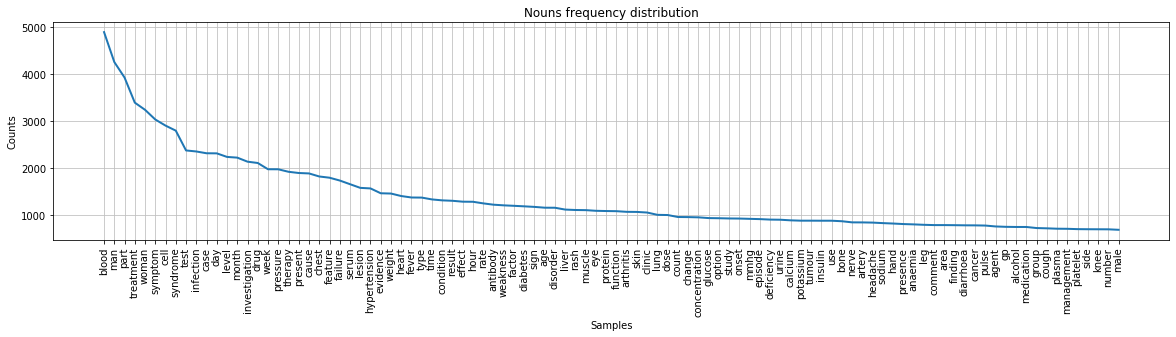

In [14]:
allNounsTokenised = word_tokenize(' '.join(joinedDf.textNoun))
allNounsTokenised = [word for word in allNounsTokenised if word not in stopWordsList]
fdist = FreqDist(allNounsTokenised)
plt.figure(figsize=(20,4))
plt.title('Nouns frequency distribution')
fdist.plot(100, cumulative=False)
plt.show()